# Benchmark cell fate and velocity identifiability

Notebook for evaluate cellular velocity and cell fate identifiability

## Library imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "pancreatic_endocrine"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [6]:
TERMINAL_STATES = ["Alpha", "Beta", "Delta", "Epsilon"]

## Function defination

In [7]:
def cal_cell_fate(adata, terminal_states, cluster_key, n_states=7):
    """Cellrank's typical analysis pipeline."""
    vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    estimator = cr.estimators.GPCCA(combined_kernel)

    ## evaluate the fate prob on original space
    estimator.compute_macrostates(n_states=n_states, n_cells=30, cluster_key=cluster_key)
    ## set a high number of states, and merge some of them and rename
    macrostate = estimator.macrostates.cat.categories.tolist()
    terminal_states_recovered = list(set(macrostate).intersection(terminal_states))

    ## check if all terminal state is coverred
    if len(set(terminal_states_recovered).intersection(terminal_states)) != len(terminal_states):
        ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
    estimator.set_terminal_states(terminal_states)
    estimator.compute_fate_probabilities(solver="direct")
    fb = estimator.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fb.names.tolist()
    fb = pd.DataFrame(fb, index=sampleID, columns=fate_name)

    return fb

## Data loading

In [8]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

In [9]:
palette = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))

## Model loading

In [10]:
adata_m = []
velo_m = []
for nrun in range(0, 5):
    model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / f"rgv_model_{nrun}"
    ### load model
    vae = REGVELOVI.load(model, adata)
    # grn1 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
    set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)
    adata_m.append(adata.copy())
    velo_m.append(adata.layers["velocity"])

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_0/model.pt already downloaded                                                                       
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_1/model.pt already downloaded                                                                       


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_2/model.pt already downloaded                                                                       


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_3/model.pt already downloaded                                                                       


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/perturb_repeat_runs/rgv_
         model_4/model.pt already downloaded                                                                       


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


## Cellular velocity

In [11]:
velo_arrays = np.stack(velo_m, axis=2)
N = adata.shape[0]

In [12]:
# Calculate pairwise cell correlation among two arrays
correlations = []
for i in range(velo_arrays.shape[2] + 1):
    for j in range(i + 1, (velo_arrays.shape[2])):
        if i != j:
            correlation_matrix = np.corrcoef(velo_arrays[:, :, i], velo_arrays[:, :, j])
            # Extract upper triangle part (excluding diagonal)
            correlation_matrix = correlation_matrix[0:N, N : (2 * N)]
            corr = np.diag(correlation_matrix)
            corr = [
                np.mean(np.array(corr)[adata.obs["clusters"] == "Alpha"]),
                np.mean(np.array(corr)[adata.obs["clusters"] == "Beta"]),
                np.mean(np.array(corr)[adata.obs["clusters"] == "Delta"]),
                np.mean(np.array(corr)[adata.obs["clusters"] == "Epsilon"]),
            ]
            correlations.append(corr)

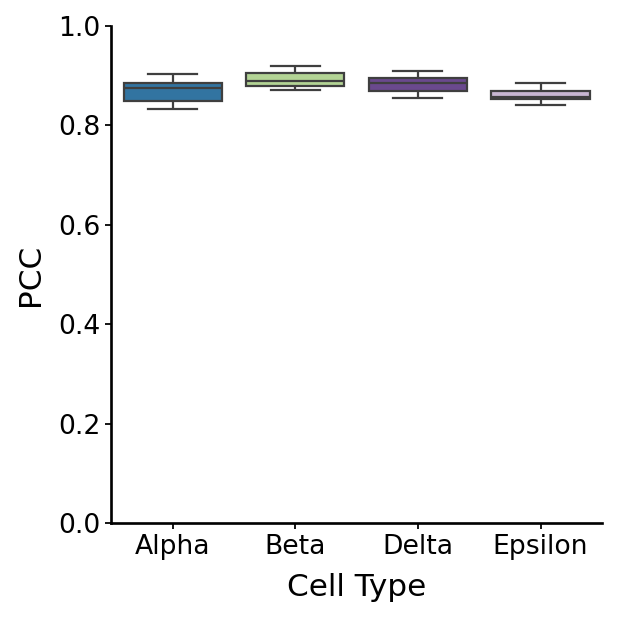

In [13]:
correlations = np.array(correlations)

df = pd.DataFrame(
    {
        "Correlation": correlations[:, 0].tolist()
        + correlations[:, 1].tolist()
        + correlations[:, 2].tolist()
        + correlations[:, 3].tolist(),
        "Group": np.repeat(TERMINAL_STATES, correlations.shape[0]),
    }
)

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [14]:
df_rgv_velo = df.copy()

## Cell fate

In [15]:
fate_list = []
for n, ad in enumerate(adata_m):
    fate = cal_cell_fate(ad, terminal_states=TERMINAL_STATES[:3], cluster_key="clusters", n_states=8)
    fate.columns = fate.columns + f"_{n}"
    fate_list.append(fate)

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [16]:
fate_all = pd.concat(fate_list, axis=1)

correlation_results = {}
for fate in TERMINAL_STATES[:3]:
    fate_cols = [f"{fate}_{i}" for i in range(5)]
    fate_df = fate_all[fate_cols]
    correlation_results[f"{fate}"] = fate_df.corr()

In [17]:
corr_all = []
for fate in TERMINAL_STATES[:3]:  # Assuming there are 4 metrics
    correlation_matrix = correlation_results[f"{fate}"]
    corr_pairwise = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    corr_all = corr_all + corr_pairwise.stack().tolist()

df = pd.DataFrame(
    {"Correlation": corr_all, "Group": np.repeat(TERMINAL_STATES[:3], len(corr_pairwise.stack().tolist()))}
)

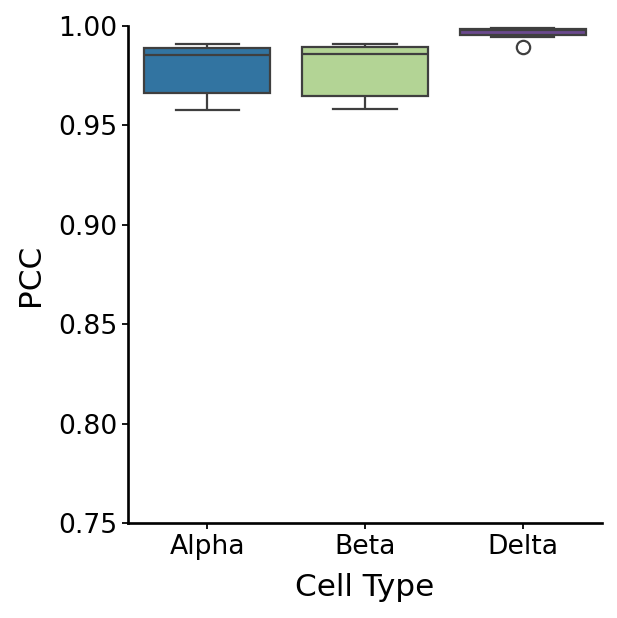

In [18]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0.75, 1)
    plt.tight_layout()
    plt.show()

In [19]:
df_rgv_fb = df.copy()

## Using veloVI as cell fate analysis baseline

In [20]:
fate_list = []
for n in range(5):
    ad = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_velovi_run{n}")
    fate = cal_cell_fate(ad, terminal_states=TERMINAL_STATES[:3], cluster_key="clusters", n_states=10)
    fate.columns = fate.columns + f"_{n}"
    fate_list.append(fate)

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

In [21]:
fate_all = pd.concat(fate_list, axis=1)

correlation_results = {}
for fate in TERMINAL_STATES[:3]:
    fate_cols = [f"{fate}_{i}" for i in range(5)]
    fate_df = fate_all[fate_cols]
    correlation_results[f"{fate}"] = fate_df.corr()

In [22]:
corr_all = []
for fate in TERMINAL_STATES[:3]:  # Assuming there are 4 metrics
    correlation_matrix = correlation_results[f"{fate}"]
    corr_pairwise = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    corr_all = corr_all + corr_pairwise.stack().tolist()

df = pd.DataFrame(
    {"Correlation": corr_all, "Group": np.repeat(TERMINAL_STATES[:3], len(corr_pairwise.stack().tolist()))}
)

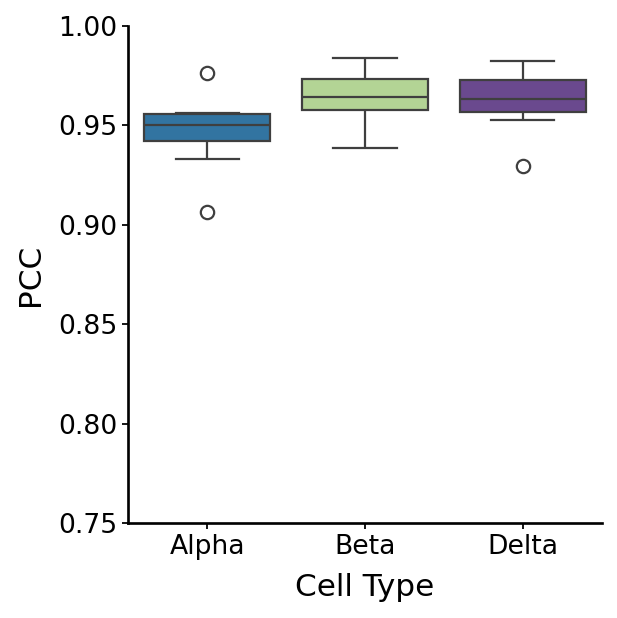

In [23]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0.75, 1)
    plt.tight_layout()
    plt.show()

In [24]:
df_vi_fb = df.copy()

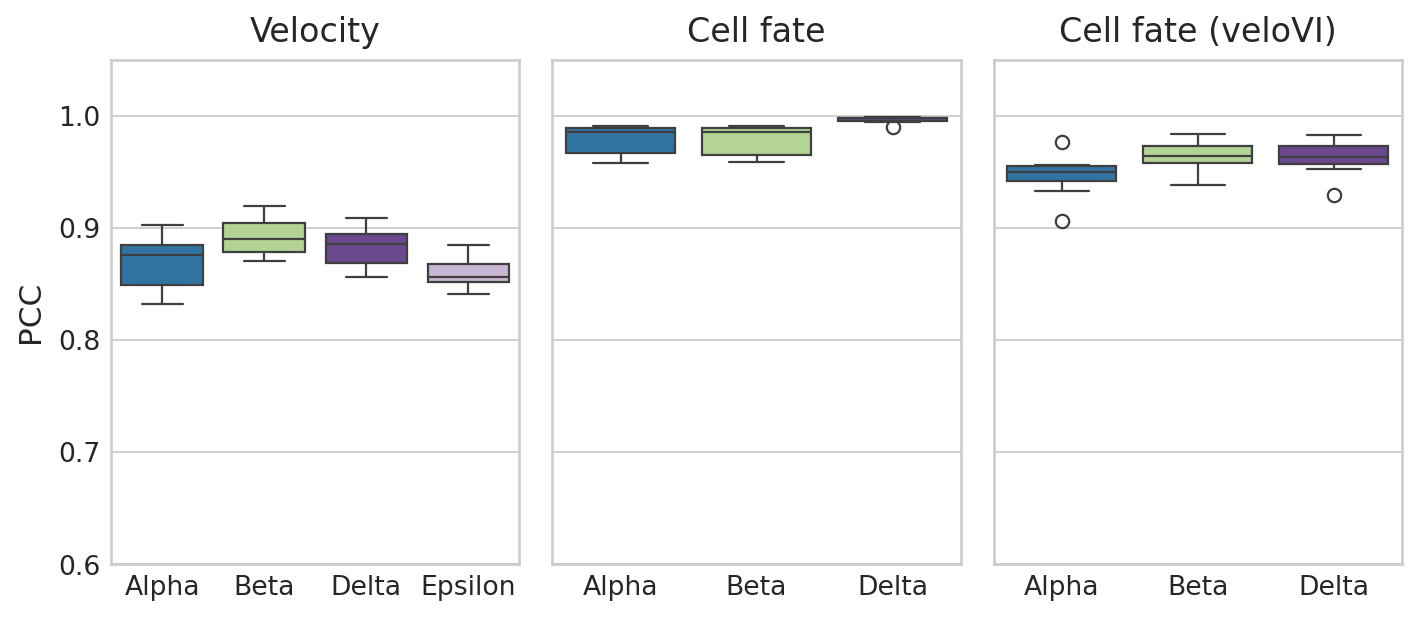

In [25]:
# Create figure with two subplots
with mplscience.style_context():  # Entering the custom style context
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True)  # 1 row, 2 columns

    # Loop over the subplots and plot data for each run
    ax = axes[0]
    sns.boxplot(y="Correlation", x="Group", data=df_rgv_velo, ax=ax, palette=palette)
    ax.set_title("Velocity")
    ax.set_xlabel("")
    ax.set_ylabel("PCC")

    ax = axes[1]
    sns.boxplot(y="Correlation", x="Group", data=df_rgv_fb, ax=ax, palette=palette)
    ax.set_title("Cell fate")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axes[2]
    sns.boxplot(y="Correlation", x="Group", data=df_vi_fb, ax=ax, palette=palette)
    ax.set_title("Cell fate (veloVI)")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set a common ylabel
    axes[0].set_ylabel("PCC")
    plt.ylim(0.6, 1.05)

    # Show the plot
    plt.tight_layout()

    if SAVE_FIGURES:
        save_path = FIG_DIR / DATASET / "Identifiability_Benchmark.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")
    plt.show()

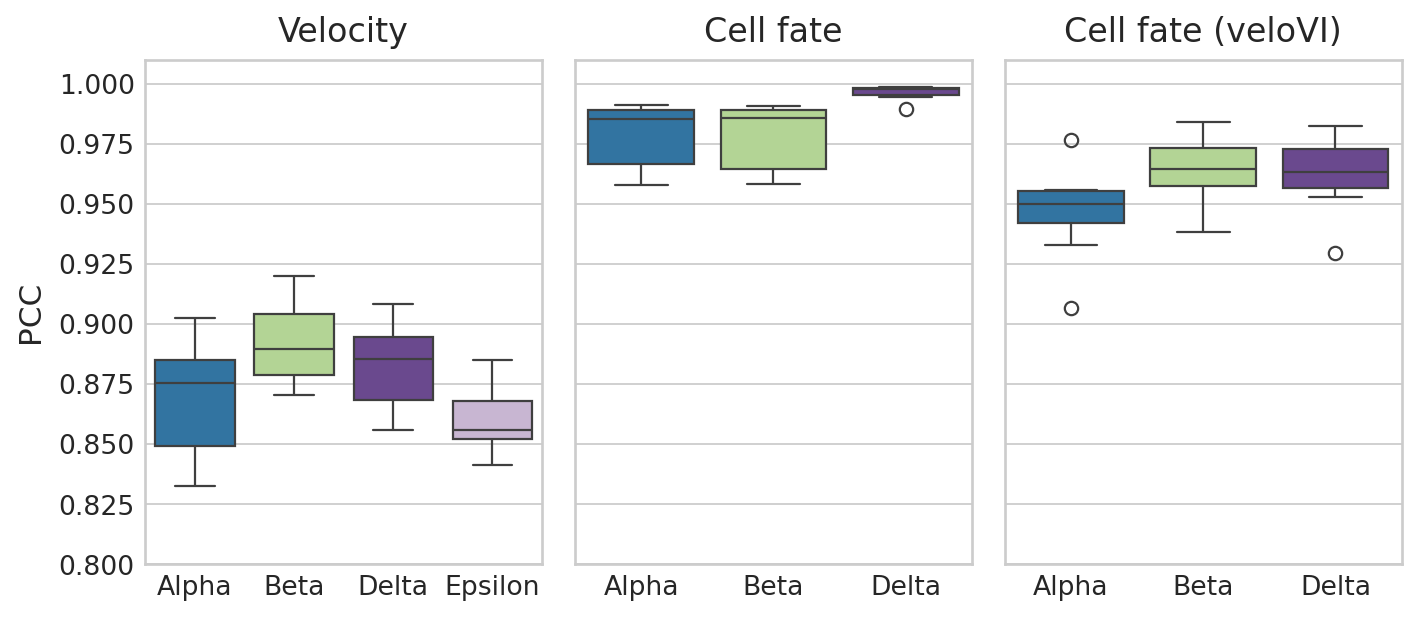

In [27]:
# Create figure with two subplots
with mplscience.style_context():  # Entering the custom style context
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True)  # 1 row, 2 columns

    # Loop over the subplots and plot data for each run
    ax = axes[0]
    sns.boxplot(y="Correlation", x="Group", data=df_rgv_velo, ax=ax, palette=palette)
    ax.set_title("Velocity")
    ax.set_xlabel("")
    ax.set_ylabel("PCC")

    ax = axes[1]
    sns.boxplot(y="Correlation", x="Group", data=df_rgv_fb, ax=ax, palette=palette)
    ax.set_title("Cell fate")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axes[2]
    sns.boxplot(y="Correlation", x="Group", data=df_vi_fb, ax=ax, palette=palette)
    ax.set_title("Cell fate (veloVI)")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set a common ylabel
    axes[0].set_ylabel("PCC")
    plt.ylim(0.8, 1.01)

    # Show the plot
    plt.tight_layout()

    if SAVE_FIGURES:
        save_path = FIG_DIR / DATASET / "Identifiability_Benchmark.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")
    plt.show()